In [15]:
# configure logging in jupyter
import sys
import logging
logger = logging.getLogger()
handler = logging.StreamHandler(sys.stderr)
handler.setFormatter(logging.Formatter("%(name)s:%(levelname)s:%(message)s"))
logger.handlers = [handler]

# Load the trained model

In [16]:
import tensorflow as tf

model_float = tf.keras.models.load_model("./cifar10_model.h5")
model_float.build()

model_float.summary()

Model: "CIFAR10_benchmark_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16,

# Prepare the data

In [17]:
import numpy as np

# download dataset, rescale and cast to float32
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
scale = tf.constant(255, dtype=tf.dtypes.float32)
data = {
    "x_train": np.float32(train_images / scale - 0.5),
    "y_train": np.float32(train_labels),
    "x_test": np.float32(test_images / scale - 0.5),
    "y_test": np.float32(test_labels),
}

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# create example dataset of the first example of each class
sorted_inds = np.argsort(data["y_test"], axis=0, kind="mergesort")
subset_inds = sorted_inds[
    np.searchsorted(
        data["y_test"][sorted_inds].flatten(),
        np.arange(10),
    )
]
examples = [(data["x_test"][j:j+1], int(data["y_test"][j][0])) for j in subset_inds.flatten()]

Evaluate the trained, floating-point model

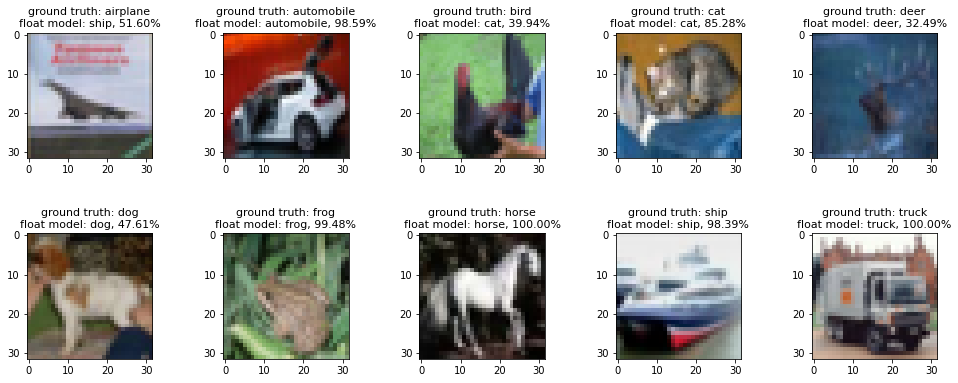

In [18]:
from matplotlib import pyplot as plt
from collections import defaultdict

prediction_summaries = defaultdict(dict)

def plot_examples(title_lines):
    plt.figure(figsize=(17, 6))
    plt.subplots_adjust(hspace=.6)
    for k, (example, cls_idx) in enumerate(examples):
        cls_name = classes[cls_idx]
        plt.subplot(2, 5, k + 1)
        plt.imshow(example[0] + .5)
        plt.title(
            '\n'.join(["ground truth: " + cls_name] + [prediction_summaries[cls_name][key] for key in title_lines]),
            fontsize=11
        )

for example, cls_idx in examples:
    cls_name = classes[cls_idx]
    predictions = model_float.predict(example)
    pred_idx = predictions.argmax(axis=1)[0]
    top1 = predictions[0, pred_idx]
    prediction_summaries[cls_name]['float'] = f"float model: {classes[pred_idx]}, {top1:.2%}"
        
plot_examples(["float"])

# Quantize the model

We provide helpers for the quantization.


In [19]:
logger.setLevel(logging.INFO)

from tflite2xcore.utils import quantize_keras_model

# use a few test images as representative dataset
representative_data = data["x_test"][:100]

# quantize model
model_quant = quantize_keras_model(
    model_float, representative_data=representative_data, show_progress_step=10,
)

model_quant_path = "./model_quant.tflite"
with open(model_quant_path, "wb") as fd:
    s = fd.write(model_quant)

tensorflow:INFO:Assets written to: /tmp/tmpkgdaarj0/assets
root:INFO:Converter quantization processed examples     10/100
root:INFO:Converter quantization processed examples     20/100
root:INFO:Converter quantization processed examples     30/100
root:INFO:Converter quantization processed examples     40/100
root:INFO:Converter quantization processed examples     50/100
root:INFO:Converter quantization processed examples     60/100
root:INFO:Converter quantization processed examples     70/100
root:INFO:Converter quantization processed examples     80/100
root:INFO:Converter quantization processed examples     90/100
root:INFO:Converter quantization processed examples    100/100


Evaluate the quantized model

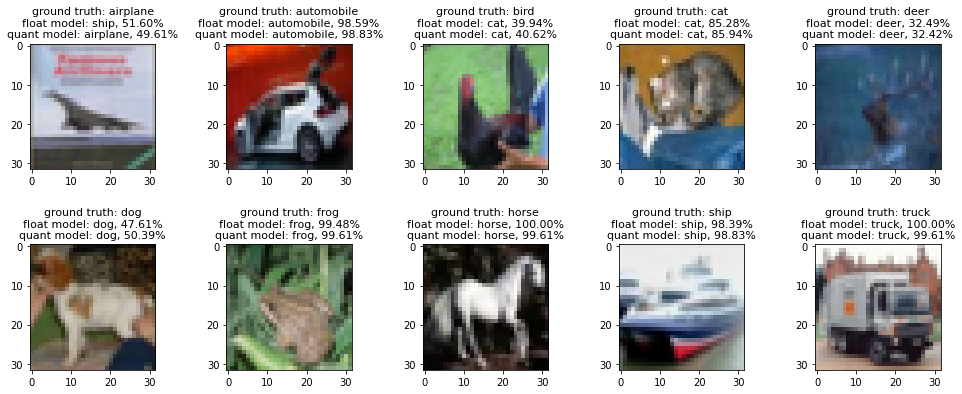

In [20]:
from tflite2xcore.utils import quantize, dequantize
from tflite2xcore.utils import (
    apply_interpreter_to_examples  # sets input tensors, invokes the interpreter, retrieves outputs
)

interpreter_quant = tf.lite.Interpreter(model_content=model_quant)
input_quantization = interpreter_quant.get_input_details()[0]["quantization"]
output_quantization = interpreter_quant.get_output_details()[0]["quantization"]
    
for example, cls_idx in examples:
    cls_name = classes[cls_idx]
    quantized_example = quantize(example, *input_quantization)
    predictions = apply_interpreter_to_examples(interpreter_quant, quantized_example)
    predictions = dequantize(predictions, *output_quantization)
    pred_idx = predictions.argmax(axis=1)[0]
    top1 = predictions[0, pred_idx]
    prediction_summaries[cls_name]['quant'] = f"quant model: {classes[pred_idx]}, {top1:.2%}"

plot_examples(["float", "quant"])

# Convert and optimize the model for xcore.ai

In [21]:
logger.setLevel(logging.ERROR)

from tflite2xcore.converter import convert as convert_to_xcore

model_xcore_path = "./model_xcore.tflite"

convert_to_xcore(model_quant_path, model_xcore_path)